In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns

import base64
import requests

## Importing, curating and exploring historic seismic data from SSN

In [7]:
#Data retrieved from Mexican Seismological Service from UNAM (http://www2.ssn.unam.mx:8080/catalogo/#)
#Data contains 262,782 rows with data from 1900 to September 2022 with historic seisms detection

#data = pd.read_csv('SSNMX_19000101_20221012.csv')

url = 'https://github.com/eflopezruiz/19SeptemberCDMX/blob/64b15e645f4e4851d1d1f49c1602f61827aa5b2f/SSNMX_19000101_20221012.csv?raw=true'
data = pd.read_csv(url,low_memory=False)
print(data.shape)
print(data.info())
data.head(3)

(262782, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262782 entries, 0 to 262781
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Fecha                       262782 non-null  object 
 1   Hora                        262782 non-null  object 
 2   Magnitud                    262782 non-null  object 
 3   Latitud                     262782 non-null  float64
 4   Longitud                    262782 non-null  float64
 5   Profundidad                 262782 non-null  object 
 6   Referencia de localizacion  262782 non-null  object 
 7   Fecha UTC                   262782 non-null  object 
 8   Hora UTC                    262782 non-null  object 
 9   Estatus                     262782 non-null  object 
dtypes: float64(2), object(8)
memory usage: 20.0+ MB
None


,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Fecha UTC,Hora UTC,Estatus
0,1/20/1900,0:33:30,7.4,20.0,-105.0,33,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1/20/1900,6:33:30,revisado
1,5/16/1900,14:12:00,6.9,20.0,-105.0,33,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",5/16/1900,20:12:00,revisado
2,3/5/1901,4:45:00,6.9,25.0,-110.0,33,"100 km al NORESTE de LA PAZ, BCS",3/5/1901,10:45:00,revisado


In [8]:
#Adjust columns to homogenize datatypes 
print(data.Magnitud.unique())

#'No calculable' value is discarded keeping in mind that Magnitude is the main attribute to differ strong from mild seismic events
data = data[data.Magnitud != 'no calculable']
#Magnitud field is then tranformed into float type
data['Magnitud'] = data.Magnitud.astype(float)

print(data.info())

['7.4' '6.9' '7' '7.5' '7.7' '7.1' '7.6' '6.6' '7.2' '6.5' '6.7' '6.8'
 '6.4' '7.8' '8.2' '7.3' '7.9' '4.3' '4.8' '3.5' 'no calculable' '4.4'
 '4.6' '4.5' '5' '5.1' '3.7' '3.1' '4.1' '5.3' '4.9' '4.7' '4.2' '5.4'
 '6.3' '3.3' '5.6' '3.6' '4' '3.9' '5.5' '6' '5.2' '3.8' '3' '6.1' '3.2'
 '3.4' '2.9' '5.7' '5.9' '2.8' '2.7' '2.2' '2.6' '2.5' '1.6' '2.4' '2.1'
 '1.9' '1.5' '2.3' '2' '1.7' '5.8' '6.2' '8.1' '8' '1.8' '1.2' '1.4' '1.3'
 '1' '0.6' '1.1' '0.3' '0.9']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 245133 entries, 0 to 262781
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Fecha                       245133 non-null  object 
 1   Hora                        245133 non-null  object 
 2   Magnitud                    245133 non-null  float64
 3   Latitud                     245133 non-null  float64
 4   Longitud                    245133 non-null  float64
 5   Profundidad   

<AxesSubplot:xlabel='Magnitud', ylabel='Count'>

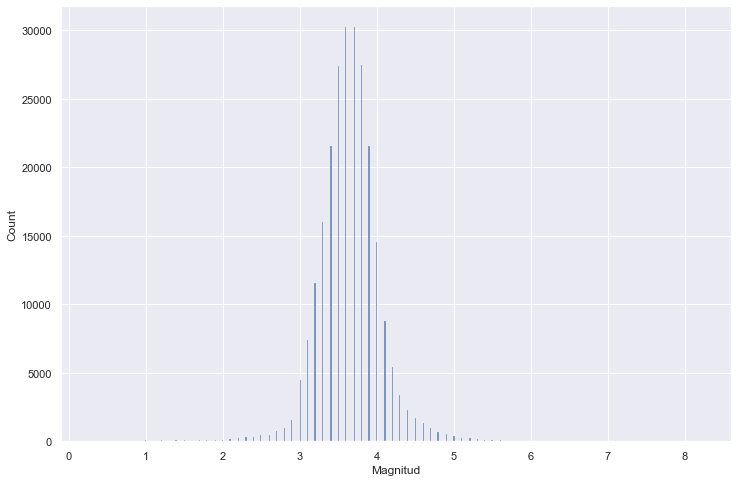

In [11]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data = data, x = 'Magnitud')